### Set directory and session info

In [12]:
# imgPath = '/Volumes/genie/Jihong_GENIE_stuff/Voltron-ST&Kv2.1/181221/dish_2/cell_3/imaging/'
imgPath = '/Users/zhengj10/Desktop/GEVI_example'


### Import modules

In [13]:
%pylab inline 
%matplotlib inline
import numpy as np
import re
import thunder
import sys
import os
from sima.misc.imagej import read_imagej_roi_zip
from shapely.geometry import MultiPolygon, Point
from shapely.geometry import Polygon as shapelyPolygon
from itertools import product as product
import tifffile as tff
from extraction.model import ExtractionModel
from glob import glob
import matplotlib.pyplot as plt


Populating the interactive namespace from numpy and matplotlib


/Users/zhengj10/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['product', 'trace']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Thunder extration

In [14]:
# reference = tff.TiffFile(imgPath + '/376.4.tif')
# reference = reference.asarray()


In [15]:
# print reference.shape
# refMean = np.mean(reference, axis=0)
# print refMean.shape


In [16]:
# plt.imshow(refMean)
# plt.show()


In [17]:
imgFiles = glob(imgPath + '/*.tif')
imgFiles

['/Users/zhengj10/Desktop/GEVI_example/376.10369.tif']

In [18]:
sumPath = imgPath + '/summary'
roiLoadName = sumPath + '/' + os.path.splitext(os.path.basename(imgFiles[0]))[0] + '_RoiSet.zip'
roiList = read_imagej_roi_zip(roiLoadName)
numOfRois = shape(roiList)[0]
print ('Number of ROIs: ' + str(numOfRois))

numOfTrials = len(glob(imgPath + '/*.tif'))
print ('The number of trials is: ' + str(numOfTrials))

traces = {}
roiAreaList = {}
roiCoordinates = []
for roiNum in range(numOfRois):
    polygon1 = shapelyPolygon(roiList[roiNum]['polygons'])
    x_min, y_min, x_max, y_max = polygon1.bounds
    roiCoordinates.append(polygon1.centroid)
    points = [Point(x, y) for x, y in
                 product(np.arange(int(x_min), np.ceil(x_max)),
                 np.arange(int(y_min), np.ceil(y_max)))]

    pointsInPoly = filter(polygon1.contains, points)
    roiAllPix = []
    for point in pointsInPoly:
        x = int(point.x)
        y = int(point.y)
        roiSinglePix = [y, x] # need to switch x, y shown in Fiji
        roiAllPix.append(roiSinglePix)
    roiAreaList[roiNum] = roiAllPix

regions = []

for roiNum in range(numOfRois):
    regions.append(roiAreaList[roiNum])

# fileName = mouseID + '_' + fovID + '_' + studyID

meanImgFiles = glob(imgPath + '/*.tif')
meanImgFiles = sorted(meanImgFiles)
for imgFile in (meanImgFiles):
    print imgFile

for trialNum in range (len(meanImgFiles)):
    data = tff.TiffFile(meanImgFiles[trialNum])
    data = data.asarray()  # need to convert to array or there is an error on transform step
    print (data.shape)
    em = ExtractionModel(regions)
    trace = em.transform(data)
    trace = trace.toarray()
    print (trace.shape)
    traces[trialNum] = trace
print ('ROI extraction completed')


Number of ROIs: 2
The number of trials is: 1
/Users/zhengj10/Desktop/GEVI_example/376.10369.tif
(24000, 32, 32)
(2, 24000)
ROI extraction completed


In [19]:
# roiCenter = []
# for point in (roiCoordinates):
#     a = int(point.x)
#     b = int(point.y)
#     roiCenter.append([a,b])
# roiCenter


In [20]:
def computeDff(singleTrace, shutterCloseFrames = 0, stimStart = 2000, frameInterval = 1, fb = 0):
    stopFrame = int(stimStart//frameInterval) - shutterCloseFrames
    startFrame = stopFrame - 500
    f0 = np.mean(singleTrace[startFrame : stopFrame])
    df = singleTrace - f0
    dff = df/(f0-fb)
    return f0, dff

### Reshape data format

In [21]:
raw_AllTrials_ROIs = []
f0_AllTrials_ROIs = []
dff_AllTrials_ROIs = []
for trialNum in range(numOfTrials):
    raw_SingleTrial_ROIs = []
    f0_SingleTrial_ROIs = []
    dff_SingleTrial_ROIs = []
    for roiNum in range(numOfRois):
        raw = traces[trialNum]
        if roiNum == 0:                              # New added code to substract fb, which is always the 1st roi
            trace_fb = raw[roiNum]
            fb = np.mean(raw[roiNum][1500:2000])        # Pick up 20 frames before stim start
            continue
        f0, dff = computeDff(raw[roiNum], fb = fb)   # fb = fb kwargs added
        raw_SingleTrial_ROIs.append(raw[roiNum,:])
        f0_SingleTrial_ROIs.append(f0)
        dff_SingleTrial_ROIs.append(dff)
    raw_AllTrials_ROIs.append(raw_SingleTrial_ROIs)
    f0_AllTrials_ROIs.append(f0_SingleTrial_ROIs)
    dff_AllTrials_ROIs.append(dff_SingleTrial_ROIs)
print ('Raw traces stored in list')
print ('Dff traces stored in list')
raw_AllTrials_ROIs_asArray = np.array(raw_AllTrials_ROIs)
dff_AllTrials_ROIs_asArray = np.array(dff_AllTrials_ROIs)
print (raw_AllTrials_ROIs_asArray.shape)
print (dff_AllTrials_ROIs_asArray.shape)


Raw traces stored in list
Dff traces stored in list
(1, 1, 24000)
(1, 1, 24000)


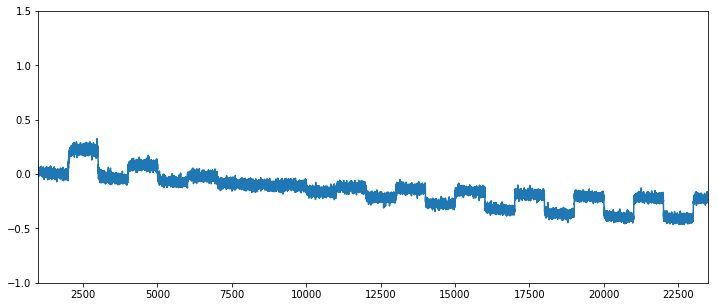

In [22]:
fig = plt.figure(figsize=(12,5))
plt.plot(dff_AllTrials_ROIs_asArray[0,0,:])
plt.xlim(1000,23500)
plt.ylim(-1,1.5)
plt.show()
fig.savefig(imgPath + '/figure/' + os.path.splitext(os.path.basename(imgFiles[0]))[0] + '.png', dpi = 1200)


In [ ]:
import scipy.signal as ss

In [ ]:
a = ss.medfilt(dff_AllTrials_ROIs_asArray[0,0,:], kernel_size=5)
a *= 100

In [ ]:
fig = plt.figure(figsize=(12,6))
plt.plot(a, 'b')
plt.xlim(2600,5300)
# plt.ylim(0.05,-0.16)
plt.ylim(5,-15.5)
plt.show()
# fig.savefig('/Users/zhengj10/Desktop/GENIE/Meeting/GEVI/181218/Voltron/imaging.png', dpi = 1200)


### Save traces and ROI coordinates to mat file

In [ ]:
import scipy.io as sio

sio.savemat(sumPath + '/' + '_raw.mat', dict(raw=raw_AllTrials_ROIs))
sio.savemat(sumPath + '/' + '_f0.mat', dict(f0=f0_AllTrials_ROIs))
sio.savemat(sumPath + '/' + '_dff.mat', dict(dff=dff_AllTrials_ROIs))
# scipy.io.savemat(matlabPath + '/' + '_roiCenter.mat', dict(roiCenter=roiCenter))


### Single ROI for all trials & all ROIs for single trial

### Single ROI for all trials & all ROIs for single trial (raw data)

In [ ]:
# Single ROI for all trials
trialMap = {1: '1 Hz',
            2: '5 Hz',
            3: '10 Hz',
            4: '20 Hz',
            5: '40 Hz',
            6: '80 Hz',
            7: '160 Hz' 
              }

roiNum = 0
numOfFrames = dff_AllTrials_ROIs_asArray.shape[2]
plt.figure(figsize=(6,6))

ax1 = plt.subplot(121)
for trialNum in range (numOfTrials):
    ax1.plot(raw_AllTrials_ROIs_asArray[trialNum, roiNum, 50:], lw=0.7, label=trialMap[trialNum+1])
leg1 = ax1.legend()
leg1.get_frame().set_linewidth(0.0)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')
ax1.set_title(sensor)
ax1.set_xlabel('Frame #', size=12)
ax1.set_ylabel('F', size=12)


# All ROIs for single trial
trialNum = 4

ax2 = plt.subplot(122)
for roiNum in range (numOfRois):
    ax2.plot(raw_AllTrials_ROIs_asArray[trialNum, roiNum, 50:], lw=0.5, label='Roi_' + str(roiNum+1))
leg2 = ax2.legend()
leg2.get_frame().set_linewidth(0.0)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.yaxis.set_ticks_position('left')
ax2.xaxis.set_ticks_position('bottom')
ax2.set_title(sensor)
ax2.set_xlabel('Frame #', size=12)
ax2.set_ylabel('F', size=12)
plt.show()
